In [ ]:
#focal loss可以解决极度不平衡政正负样本下，grad被大量易分类样本主导，最终损失下降缓慢，模型效果提升慢的问题。

In [1]:
import numpy as np
from toad.metrics import KS,AUC
import  matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import  XGBClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb  
from xgboost import plot_importance 
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numbers
import datetime
import collections
import random
import sys
import pickle
from sklearn.model_selection import train_test_split
from importlib import reload
from matplotlib import pyplot as plt
import operator
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from toad.metrics import KS


Bad key "text.kerning_factor" on line 4 in
D:\python\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#focal loss的定义
def logistic_obj(p,dtrain):
    y = dtrain.get_label()
    p=1.0/ (1.0 + np.exp(-p))
    grad = p*(1 - p)*(alpha*gamma*y*(1 - p)**gamma*np.log(p)/(1 - p) - alpha*y*(1 - p)**gamma/p - 
                      gamma*p**gamma*(1 - alpha)*(1 - y)*np.log(1 - p)/p + p**gamma*(1 - alpha)*(1 - y)/(1 - p))
   
    hess = p*(1 - p)*(p*(1 - p)*(
        -alpha*gamma**2*y*(
        1 - p)**gamma*np.log(p)/(1 - p)**2 + alpha*gamma*y*(1 - p)**gamma*np.log(p)/(1 - p)**2 + 2*alpha*gamma*y*(1 - p)**gamma/(p*(1 - p)) + alpha*y*(
        1 - p)**gamma/p**2 - gamma**2*p**gamma*(1 - alpha)*(1 - y)*np.log(1 - p)/p**2 + 2*gamma*p**gamma*(
        1 - alpha)*(1 - y)/(p*(1 - p)) + gamma*p**gamma*(1 - alpha)*(1 - y)*np.log(1 - p)/p**2 + p**gamma*(
        1 - alpha)*(1 - y)/(1 - p)**2) - p*(alpha*gamma*y*(1 - p)**gamma*np.log(p)/(1 - p) - alpha*y*(
        1 - p)**gamma/p - gamma*p**gamma*(1 - alpha)*(1 - y)*np.log(1 - p)/p + p**gamma*(1 - alpha)*(
        1 - y)/(1 - p)) + (1 - p)*(alpha*gamma*y*(1 - p)**gamma*np.log(p)/(1 - p) - alpha*y*(
        1 - p)**gamma/p - gamma*p**gamma*(1 - alpha)*(1 - y)*np.log(1 - p)/p + p**gamma*(1 - alpha)*(1 - y)/(
        1 - p)))

    return grad, hess

In [3]:
#导入数据
data=pd.read_csv('dt_data0.csv',encoding='utf-8')
for i in range(1,30):
    data_tmp=pd.read_csv('dt_data'+str(i)+'.csv',encoding='utf-8')
    data=pd.concat([data,data_tmp],axis=0)
data=data.drop('Unnamed: 0',axis=1)
data_train=data[(data.business_date=='2020-09-30')|(data.business_date=='2020-06-30')|(data.business_date=='2020-12-31')]
data_test=data[(data.business_date=='2021-03-31')]
target='collection_flag'

exclude_list=['rating','id_number_a','business_date', 'bal_sum_a','begindate_min','id_number',
              'stat_month','id_number_r','first_credit_date','loanacno_1st','score_date',
              'loan_begin_date_1st','loan_channel_1st','create_date','collection_flag',
              'loan_last_ovd_end_date','quota_last_up_date', 'coll_in_last_date']
train_x=data_train[[x for x in data.columns if x not in exclude_list]]
train_y=data_train[target]
test_x=data_test[[x for x in data.columns if x not in exclude_list]]
test_y=data_test[target]

In [4]:
def feature_out(x,y):
    '''
    :param x: pd.series
    :param y: pd.series
    :return:
    '''
    result_df = pd.DataFrame(columns=['feature', 'good', 'bad', 'total', 'good_pct', 'bad_pct', 'total_pct', 'bad_rate',
                                      'woe', 'iv', 'bad_cumsum_pct', 'good_cumsum_pct', 'ks'])
    df=pd.concat([x,y],axis=1)
    df.columns=[x.name,y.name]
    group=df.groupby(x.name)[y.name]
    result_df=group.agg([('good',lambda y: (y==0).sum()),
                ('bad',lambda y: (y==1).sum()),
               ('total', 'count')])
    result_df['good_pct']=result_df['good']/result_df['good'].sum()
    result_df['bad_pct']=result_df['bad']/result_df['bad'].sum()
    result_df['total_pct']=result_df['total']/result_df['total'].sum()
    result_df['bad_rate']=result_df['bad']/result_df['total']
    result_df['woe']=np.log(result_df['good_pct']/result_df['bad_pct'])
    result_df['iv']=((result_df['good_pct']-result_df['bad_pct'])*result_df['woe']).sum()
    result_df['feature']=x.name
    result_df['bad_cumsum_pct']=result_df['bad'].cumsum()/result_df['bad'].sum()
    result_df['good_cumsum_pct'] = result_df['good'].cumsum() / result_df['good'].sum()
    result_df['ks']=result_df['bad_cumsum_pct']-result_df['good_cumsum_pct']
    return result_df
##
def unsupervisedSplit(feature,n_bins=10,method='Quantile'):
    feature=feature[feature.notnull()]
    if method=='Quantile':
        N=len(feature)
        n=int(N/n_bins)
        SplitPointIndex=[i*n for i in range(1,n_bins)]
        rawValues=sorted(list(feature))
        SplitPoint=[int(rawValues[i]) for i in SplitPointIndex]
        return SplitPoint
    else:
        var_max,var_min=max(feature),min(feature)
        interval_len=(var_max-var_min)*1.0/n_bins
        SplitPoint=[int(var_min+i*interval_len) for i in range(1,n_bins)]
        return SplitPoint

In [8]:
#贝叶斯调参
def xgb_cv(n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda,
           learning_rate):
    res = cross_val_score(
        XGBClassifier(n_estimators=int(n_estimators),
                      max_depth=int(max_depth),
                      min_child_weight=int(min_child_weight),
                      gamma=gamma,  # float
                      subsample=subsample,
                      colsample_bytree=colsample_bytree,
                      reg_alpha=reg_alpha,
                      reg_lambda=reg_lambda,
                      learning_rate=learning_rate,
                      random_state=1643
                      ), train_x, train_y, scoring='roc_auc', cv=5).mean()
    return res
xgb_op = BayesianOptimization(
    xgb_cv,
    {'n_estimators': (60, 100),
     'max_depth': (3, 5),
     'min_child_weight': (1, 10),
     'gamma': (1, 50),
     'subsample': (0.6, 0.9),
     'colsample_bytree': (0.6, 0.9),
     'reg_alpha': (0.1, 100),
     'reg_lambda': (0.1, 100),
     'learning_rate': (0.05, 0.2),
     
     }
,random_state=9453
)
xgb_op.maximize(n_iter=30, init_points=10)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8643   |  0.8096   |  20.23    |  0.1519   |  4.377    |  3.269    |  60.91    |  66.01    |  25.66    |  0.6007   |
|  2        |  0.8639   |  0.8437   |  41.74    |  0.1652   |  4.783    |  5.283    |  90.39    |  23.43    |  67.09    |  0.8712   |


KeyboardInterrupt: 

In [9]:
#获得参数字典并添加AUC作为评判标准
params=xgb_op.max['params']
params['eval_metric']='auc'
params['n_estimators']=int(params['n_estimators'])
params['max_depth']=int(params['max_depth'])
params

{'colsample_bytree': 0.8095627056325194,
 'gamma': 20.232421499379885,
 'learning_rate': 0.1518689697175436,
 'max_depth': 4,
 'min_child_weight': 3.2694050723335204,
 'n_estimators': 60,
 'reg_alpha': 66.00622101450183,
 'reg_lambda': 25.660404593630222,
 'subsample': 0.6007006869590505,
 'eval_metric': 'auc'}

In [6]:
#将数据转化成xgb的DMatrix格式
dtrain = xgb.DMatrix(data = train_x,label = train_y)
dvalid = xgb.DMatrix(data = test_x, label = test_y )

In [9]:
#由于修改了损失函数，所以需要对输出结果进行sigmoid归一化
def sigmoid_function(z):
    fz= []
    for num in z:
        fz.append(1/(1+np.exp(-num)))
    return fz

----------focal loss--------
[09:45:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65007	valid-auc:0.66019
[5]	train-auc:0.70645	valid-auc:0.70596
[10]	train-auc:0.74595	valid-auc:0.74896
[15]	train-auc:0.83832	valid-auc:0.84423
[20]	train-auc:0.84327	valid-auc:0.84781
[25]	train-auc:0.85322	valid-auc:0.86104
[30]	train-auc:0.85896	valid-auc:0.86820
[35]	train-auc:0.86087	valid-auc:0.86727
[40]	train-auc:0.86335	valid-auc:0.87001
[45]	train-auc:0.86340	valid-auc:0.87012
[50]	train-auc:0.86340	valid-auc:0.87012
[55]	train-auc:0.86340	valid-auc:0.87012
[60]	train-auc:0.86340	valid-auc:0.87012
[65]	train-auc:0.86340	valid-auc:0.87012
[70]	trai

Train set:>>>>>>>>>>>>>
KS: 0.5946093525799366
AUC: 0.8611282214343258
Test set: >>>>>>>>>>>>>
KS: 0.5978062707293681
AUC: 0.8672108239500879
此时gamma: 0.16
----------focal loss--------
[09:57:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65007	valid-auc:0.66019
[5]	train-auc:0.70644	valid-auc:0.70595
[10]	train-auc:0.74105	valid-auc:0.74285
[15]	train-auc:0.83821	valid-auc:0.84405
[20]	train-auc:0.84743	valid-auc:0.85295
[25]	train-auc:0.85157	valid-auc:0.85793
[30]	train-auc:0.85860	valid-auc:0.86735
[35]	train-auc:0.86103	valid-auc:0.86719
[40]	train-auc:0.86110	valid-auc:0.86709
[45]	train-auc:0.86114	valid-auc:0.86725
[50]	train-auc:0.

[80]	train-auc:0.86092	valid-auc:0.86748
[85]	train-auc:0.86092	valid-auc:0.86748
[90]	train-auc:0.86113	valid-auc:0.86793
[94]	train-auc:0.86113	valid-auc:0.86793
Train set:>>>>>>>>>>>>>
KS: 0.5967352018532196
AUC: 0.8611261485416684
Test set: >>>>>>>>>>>>>
KS: 0.6024118287832416
AUC: 0.8679257733991724
此时gamma: 0.33999999999999997
----------focal loss--------
[10:08:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64975	valid-auc:0.66019
[5]	train-auc:0.69432	valid-auc:0.69887
[10]	train-auc:0.74137	valid-auc:0.74283
[15]	train-auc:0.83814	valid-auc:0.84401
[20]	train-auc:0.84662	valid-auc:0.85270
[25]	train-auc:0.85247	valid-auc:0.85890
[3

[60]	train-auc:0.86106	valid-auc:0.86760
[65]	train-auc:0.86106	valid-auc:0.86760
[70]	train-auc:0.86106	valid-auc:0.86760
[75]	train-auc:0.86106	valid-auc:0.86760
[80]	train-auc:0.86106	valid-auc:0.86760
[85]	train-auc:0.86106	valid-auc:0.86760
[90]	train-auc:0.86106	valid-auc:0.86760
[94]	train-auc:0.86106	valid-auc:0.86760
Train set:>>>>>>>>>>>>>
KS: 0.5957476901697709
AUC: 0.8610624954599931
Test set: >>>>>>>>>>>>>
KS: 0.6018328618061528
AUC: 0.8675998247781712
此时gamma: 0.52
----------focal loss--------
[10:20:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64975	valid-auc:0.66019
[5]	train-auc:0.69913	valid-auc:0.70242
[10]	train-auc:0.

[40]	train-auc:0.86040	valid-auc:0.86650
[45]	train-auc:0.86033	valid-auc:0.86653
[50]	train-auc:0.86033	valid-auc:0.86653
[55]	train-auc:0.86033	valid-auc:0.86653
[60]	train-auc:0.86033	valid-auc:0.86653
[65]	train-auc:0.86033	valid-auc:0.86653
[70]	train-auc:0.86033	valid-auc:0.86653
[75]	train-auc:0.86033	valid-auc:0.86653
[80]	train-auc:0.86033	valid-auc:0.86653
[85]	train-auc:0.86033	valid-auc:0.86653
[90]	train-auc:0.86033	valid-auc:0.86653
[94]	train-auc:0.86033	valid-auc:0.86653
Train set:>>>>>>>>>>>>>
KS: 0.5940456136454577
AUC: 0.8603339261124021
Test set: >>>>>>>>>>>>>
KS: 0.5977129658331987
AUC: 0.8665269549094856
此时gamma: 0.7
----------focal loss--------
[10:32:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through thi

[25]	train-auc:0.85278	valid-auc:0.85943
[30]	train-auc:0.85900	valid-auc:0.86793
[35]	train-auc:0.85975	valid-auc:0.86775
[40]	train-auc:0.85967	valid-auc:0.86765
[45]	train-auc:0.85967	valid-auc:0.86765
[50]	train-auc:0.85967	valid-auc:0.86765
[55]	train-auc:0.85967	valid-auc:0.86765
[60]	train-auc:0.85967	valid-auc:0.86765
[65]	train-auc:0.85967	valid-auc:0.86765
[70]	train-auc:0.85967	valid-auc:0.86765
[75]	train-auc:0.85967	valid-auc:0.86765
[80]	train-auc:0.85967	valid-auc:0.86765
[85]	train-auc:0.85967	valid-auc:0.86765
[90]	train-auc:0.85967	valid-auc:0.86765
[94]	train-auc:0.85967	valid-auc:0.86765
Train set:>>>>>>>>>>>>>
KS: 0.594356362820946
AUC: 0.8596733343638752
Test set: >>>>>>>>>>>>>
KS: 0.5989169973905919
AUC: 0.8676504520985144
此时gamma: 0.88
----------focal loss--------
[10:52:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters 

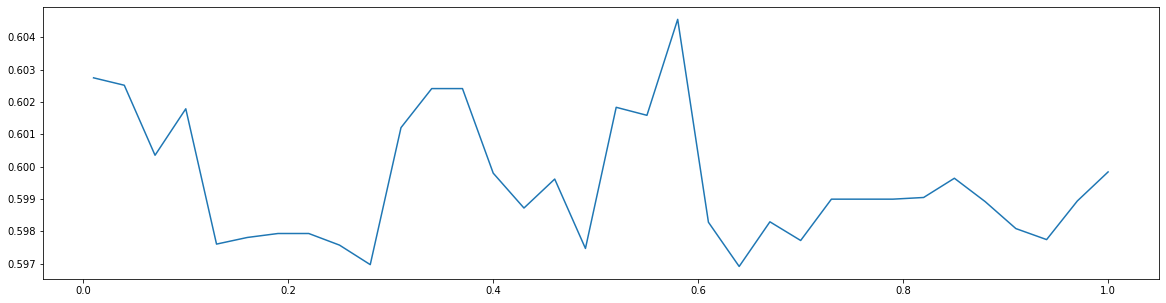

In [13]:
#开始对focal loss的自带参数gamma进行网格搜索，评判标准为测试集上KS值（与xgb中自带参数gamma不一样）
#alpha设为0.5时默认对模型无影响
K=[]
OP=[]
gam_range=np.arange(0.01,1.01,0.03)
for i in gam_range:
    gamma = i
    alpha = 0.5
    print('----------focal loss--------')
    xgbf = xgb.train(params = params, dtrain = dtrain, num_boost_round= 95, 
                 evals=[(dtrain,'train'),(dvalid,'valid')],verbose_eval = 5,obj = logistic_obj)
    prob_test=xgbf.predict(dvalid)
    prob_train=xgbf.predict(dtrain)
    prob_train=np.array(sigmoid_function(prob_train))
    prob_test=np.array(sigmoid_function(prob_test))
    print('Train set:>>>>>>>>>>>>>')
    print('KS:',KS(prob_train,train_y))
    print('AUC:',AUC(prob_train,train_y))

    print('Test set: >>>>>>>>>>>>>')
    print('KS:',KS(prob_test,test_y))
    print('AUC:',AUC(prob_test,test_y))
    print('此时gamma:',gamma)
    K= KS(prob_test,test_y)
    OP.append(K)
print(max(OP),OP.index(max(OP)))
G=OP.index(max(OP))*0.03+0.01
print('最终gamma={}'.format(G))
plt.figure(figsize=[20,5])
plt.plot(gam_range,OP)
plt.show()

In [14]:
#可以选择更高精度
K=[]
OP=[]
gam_range=np.arange(0.01,1.01,0.01)
for i in gam_range:
    gamma = i
    alpha = 0.5
    print('----------focal loss--------')
    xgbf = xgb.train(params = params, dtrain = dtrain, num_boost_round= 95, 
                 evals=[(dtrain,'train'),(dvalid,'valid')],verbose_eval = 5,obj = logistic_obj)
    prob_test=xgbf.predict(dvalid)
    prob_train=xgbf.predict(dtrain)
    prob_train=np.array(sigmoid_function(prob_train))
    prob_test=np.array(sigmoid_function(prob_test))
    print('Train set:>>>>>>>>>>>>>')
    print('KS:',KS(prob_train,train_y))
    print('AUC:',AUC(prob_train,train_y))

    print('Test set: >>>>>>>>>>>>>')
    print('KS:',KS(prob_test,test_y))
    print('AUC:',AUC(prob_test,test_y))
    print('此时gamma:',gamma)
    K= KS(prob_test,test_y)
    OP.append(K)
print(max(OP),OP.index(max(OP)))
G=OP.index(max(OP))*0.01+0.01
print('最终gamma={}'.format(G))
plt.figure(figsize=[20,5])
plt.plot(gam_range,OP)
plt.show()

----------focal loss--------
[11:04:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65007	valid-auc:0.66019


KeyboardInterrupt: 

----------focal loss--------
[11:05:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50000	valid-auc:0.50000
[5]	train-auc:0.50000	valid-auc:0.50000
[10]	train-auc:0.50000	valid-auc:0.50000
[15]	train-auc:0.50000	valid-auc:0.50000
[20]	train-auc:0.50000	valid-auc:0.50000
[25]	train-auc:0.50000	valid-auc:0.50000
[30]	train-auc:0.50000	valid-auc:0.50000
[35]	train-auc:0.50000	valid-auc:0.50000
[40]	train-auc:0.50000	valid-auc:0.50000
[45]	train-auc:0.50000	valid-auc:0.50000
[50]	train-auc:0.50000	valid-auc:0.50000
[55]	train-auc:0.50000	valid-auc:0.50000
[60]	train-auc:0.50000	valid-auc:0.50000
[65]	train-auc:0.50000	valid-auc:0.50000
[70]	trai

[0]	train-auc:0.50000	valid-auc:0.50000
[5]	train-auc:0.63057	valid-auc:0.64233
[10]	train-auc:0.66519	valid-auc:0.67477
[15]	train-auc:0.70005	valid-auc:0.70352
[20]	train-auc:0.73943	valid-auc:0.74093
[25]	train-auc:0.78235	valid-auc:0.78076
[30]	train-auc:0.83778	valid-auc:0.84562
[35]	train-auc:0.85058	valid-auc:0.85727
[40]	train-auc:0.85213	valid-auc:0.85852
[45]	train-auc:0.85113	valid-auc:0.85771
[50]	train-auc:0.85067	valid-auc:0.85737
[55]	train-auc:0.85067	valid-auc:0.85737
[60]	train-auc:0.85067	valid-auc:0.85737
[65]	train-auc:0.85067	valid-auc:0.85737
[70]	train-auc:0.85067	valid-auc:0.85737
[75]	train-auc:0.85067	valid-auc:0.85737
[80]	train-auc:0.85067	valid-auc:0.85737
[85]	train-auc:0.85067	valid-auc:0.85737
[90]	train-auc:0.85067	valid-auc:0.85737
[94]	train-auc:0.85067	valid-auc:0.85737
Train set:>>>>>>>>>>>>>
KS: 0.5787942060697159
AUC: 0.8506707635506193
Test set: >>>>>>>>>>>>>
KS: 0.5897269108129624
AUC: 0.8573750389300989
此时alpha: 0.19
----------focal loss------

[0]	train-auc:0.56662	valid-auc:0.56698
[5]	train-auc:0.65524	valid-auc:0.66444
[10]	train-auc:0.71125	valid-auc:0.71197
[15]	train-auc:0.74101	valid-auc:0.74288
[20]	train-auc:0.83806	valid-auc:0.84443
[25]	train-auc:0.84551	valid-auc:0.85093
[30]	train-auc:0.85206	valid-auc:0.85988
[35]	train-auc:0.85493	valid-auc:0.86103
[40]	train-auc:0.85885	valid-auc:0.86702
[45]	train-auc:0.85898	valid-auc:0.86699
[50]	train-auc:0.85898	valid-auc:0.86699
[55]	train-auc:0.85898	valid-auc:0.86699
[60]	train-auc:0.85898	valid-auc:0.86699
[65]	train-auc:0.85898	valid-auc:0.86699
[70]	train-auc:0.85898	valid-auc:0.86699
[75]	train-auc:0.85898	valid-auc:0.86699
[80]	train-auc:0.85898	valid-auc:0.86699
[85]	train-auc:0.85898	valid-auc:0.86699
[90]	train-auc:0.85898	valid-auc:0.86699
[94]	train-auc:0.85898	valid-auc:0.86699
Train set:>>>>>>>>>>>>>
KS: 0.5923816989152033
AUC: 0.8589837211196439
Test set: >>>>>>>>>>>>>
KS: 0.5973345616325318
AUC: 0.8669860253678712
此时alpha: 0.37
----------focal loss------

[0]	train-auc:0.65007	valid-auc:0.66019
[5]	train-auc:0.70640	valid-auc:0.70593
[10]	train-auc:0.73808	valid-auc:0.73961
[15]	train-auc:0.83770	valid-auc:0.84360
[20]	train-auc:0.84790	valid-auc:0.85370
[25]	train-auc:0.85330	valid-auc:0.86023
[30]	train-auc:0.85907	valid-auc:0.86789
[35]	train-auc:0.86082	valid-auc:0.86689
[40]	train-auc:0.86076	valid-auc:0.86678
[45]	train-auc:0.86081	valid-auc:0.86687
[50]	train-auc:0.86081	valid-auc:0.86687
[55]	train-auc:0.86081	valid-auc:0.86687
[60]	train-auc:0.86081	valid-auc:0.86687
[65]	train-auc:0.86081	valid-auc:0.86687
[70]	train-auc:0.86081	valid-auc:0.86687
[75]	train-auc:0.86081	valid-auc:0.86687
[80]	train-auc:0.86081	valid-auc:0.86687
[85]	train-auc:0.86081	valid-auc:0.86687
[90]	train-auc:0.86081	valid-auc:0.86687
[94]	train-auc:0.86081	valid-auc:0.86687
Train set:>>>>>>>>>>>>>
KS: 0.5972538533753977
AUC: 0.8608148122462947
Test set: >>>>>>>>>>>>>
KS: 0.5980590616900174
AUC: 0.8668715954355005
此时alpha: 0.55
----------focal loss------

[0]	train-auc:0.66618	valid-auc:0.67560
[5]	train-auc:0.73824	valid-auc:0.73950
[10]	train-auc:0.83438	valid-auc:0.84188
[15]	train-auc:0.84818	valid-auc:0.85533
[20]	train-auc:0.85190	valid-auc:0.85778
[25]	train-auc:0.86132	valid-auc:0.86740
[30]	train-auc:0.86247	valid-auc:0.86919
[35]	train-auc:0.86264	valid-auc:0.86971
[40]	train-auc:0.86258	valid-auc:0.86970
[45]	train-auc:0.86258	valid-auc:0.86970
[50]	train-auc:0.86258	valid-auc:0.86970
[55]	train-auc:0.86262	valid-auc:0.86974
[60]	train-auc:0.86262	valid-auc:0.86974
[65]	train-auc:0.86262	valid-auc:0.86974
[70]	train-auc:0.86262	valid-auc:0.86974
[75]	train-auc:0.86262	valid-auc:0.86974
[80]	train-auc:0.86262	valid-auc:0.86974
[85]	train-auc:0.86262	valid-auc:0.86974
[90]	train-auc:0.86413	valid-auc:0.87080
[94]	train-auc:0.86413	valid-auc:0.87080
Train set:>>>>>>>>>>>>>
KS: 0.5967118658347746
AUC: 0.8641290405953731
Test set: >>>>>>>>>>>>>
KS: 0.6002063477163677
AUC: 0.8708032625605964
此时alpha: 0.73
----------focal loss------

[0]	train-auc:0.80092	valid-auc:0.81025
[5]	train-auc:0.84302	valid-auc:0.84892
[10]	train-auc:0.84978	valid-auc:0.85678
[15]	train-auc:0.85757	valid-auc:0.86362
[20]	train-auc:0.86006	valid-auc:0.86749
[25]	train-auc:0.86231	valid-auc:0.86949
[30]	train-auc:0.86383	valid-auc:0.87055
[35]	train-auc:0.86383	valid-auc:0.87056
[40]	train-auc:0.86383	valid-auc:0.87056
[45]	train-auc:0.86383	valid-auc:0.87056
[50]	train-auc:0.86383	valid-auc:0.87056
[55]	train-auc:0.86383	valid-auc:0.87056
[60]	train-auc:0.86383	valid-auc:0.87056
[65]	train-auc:0.86383	valid-auc:0.87056
[70]	train-auc:0.86383	valid-auc:0.87056
[75]	train-auc:0.86383	valid-auc:0.87056
[80]	train-auc:0.86383	valid-auc:0.87056
[85]	train-auc:0.86383	valid-auc:0.87056
[90]	train-auc:0.86383	valid-auc:0.87056
[94]	train-auc:0.86383	valid-auc:0.87056
Train set:>>>>>>>>>>>>>
KS: 0.5972226171995809
AUC: 0.8638259409529516
Test set: >>>>>>>>>>>>>
KS: 0.6041498030209757
AUC: 0.8705639516015187
此时alpha: 0.9099999999999999
----------fo

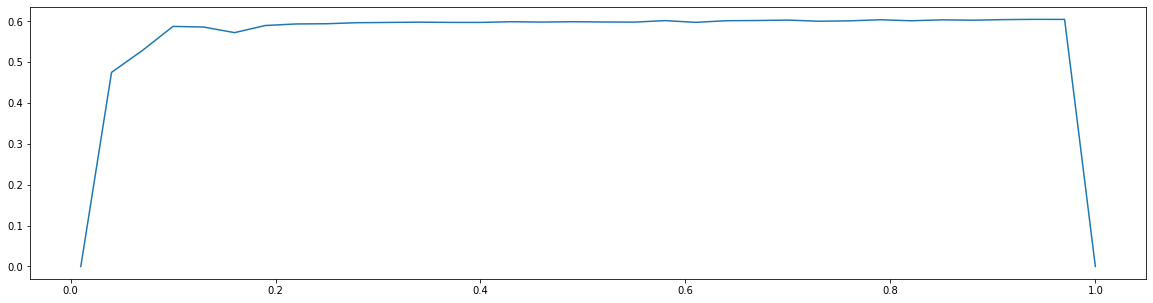

In [15]:
#接下来固定gamma，寻找最优alpha
K=[]
OP=[]
alp_range=np.arange(0.01,1.01,0.03)
for i in alp_range:
    gamma = G
    alpha = i
    print('----------focal loss--------')
    xgbf = xgb.train(params = params, dtrain = dtrain, num_boost_round= 95, 
                 evals=[(dtrain,'train'),(dvalid,'valid')],verbose_eval = 5,obj = logistic_obj)
    prob_test=xgbf.predict(dvalid)
    prob_train=xgbf.predict(dtrain)
    prob_train=np.array(sigmoid_function(prob_train))
    prob_test=np.array(sigmoid_function(prob_test))
    print('Train set:>>>>>>>>>>>>>')
    print('KS:',KS(prob_train,train_y))
    print('AUC:',AUC(prob_train,train_y))

    print('Test set: >>>>>>>>>>>>>')
    print('KS:',KS(prob_test,test_y))
    print('AUC:',AUC(prob_test,test_y))
    print('此时alpha:',alpha)
    K= KS(prob_test,test_y)
    OP.append(K)
print(max(OP),OP.index(max(OP)))
A= OP.index(max(OP))*0.03+0.01
print('最终alpha={}'.format(A))
plt.figure(figsize=[20,5])
plt.plot(alp_range,OP)
plt.show()

In [ ]:
#可以选择更高精度
K=[]
OP=[]
alp_range=np.arange(0.01,1.01,0.01)
for i in alp_range:
    gamma = G
    alpha = i
    print('----------focal loss--------')
    xgbf = xgb.train(params = params, dtrain = dtrain, num_boost_round= 95, 
                 evals=[(dtrain,'train'),(dvalid,'valid')],verbose_eval = 5,obj = logistic_obj)
    prob_test=xgbf.predict(dvalid)
    prob_train=xgbf.predict(dtrain)
    prob_train=np.array(sigmoid_function(prob_train))
    prob_test=np.array(sigmoid_function(prob_test))
    print('Train set:>>>>>>>>>>>>>')
    print('KS:',KS(prob_train,train_y))
    print('AUC:',AUC(prob_train,train_y))

    print('Test set: >>>>>>>>>>>>>')
    print('KS:',KS(prob_test,test_y))
    print('AUC:',AUC(prob_test,test_y))
    print('此时gamma:',gamma)
    K= KS(prob_test,test_y)
    OP.append(K)
print(max(OP),OP.index(max(OP)))
A = OP.index(max(OP))*0.01+0.01
print('最终alpha={}'.format(A))
plt.figure(figsize=[20,5])
plt.plot(alp_range,OP)
plt.show()

In [17]:
#区别在于多了个obj = logistic_obj,可以与普通损失函数进行对比
gamma = G
alpha = A
print('----------focal loss--------')
xgbf = xgb.train(params = params, dtrain = dtrain, num_boost_round= 100, 
                 evals=[(dtrain,'train'),(dvalid,'valid')],verbose_eval = 5,obj = logistic_obj)
print ("-----------no focal loss-----------")
xgbn = xgb.train(params = params, dtrain = dtrain, num_boost_round= 100, 
                 evals=[(dtrain,'train'),(dvalid,'valid')],verbose_eval = 5)

----------focal loss--------
[14:19:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.80091	valid-auc:0.81017
[5]	train-auc:0.84505	valid-auc:0.85036
[10]	train-auc:0.84962	valid-auc:0.85671
[15]	train-auc:0.86030	valid-auc:0.86648
[20]	train-auc:0.86068	valid-auc:0.86713
[25]	train-auc:0.86306	valid-auc:0.86943
[30]	train-auc:0.86308	valid-auc:0.86950
[35]	train-auc:0.86308	valid-auc:0.86950
[40]	train-auc:0.86308	valid-auc:0.86950
[45]	train-auc:0.86308	valid-auc:0.86950
[50]	train-auc:0.86308	valid-auc:0.86950
[55]	train-auc:0.86323	valid-auc:0.86990
[60]	train-auc:0.86323	valid-auc:0.86990
[65]	train-auc:0.86323	valid-auc:0.86990
[70]	trai

In [91]:
#查看KS值和AUC值对比
from toad.metrics import KS,AUC
prob_test_f=xgbf.predict(dvalid)
prob_train_f=xgbf.predict(dtrain)
prob_train_f=np.array(sigmoid_function(prob_train_f))
prob_test_f=np.array(sigmoid_function(prob_test_f))
prob_test_n=xgbn.predict(dvalid)
prob_train_n=xgbn.predict(dtrain)
print('----------focal loss--------')
print('Train set:>>>>>>>>>>>>>')
print('KS:',KS(prob_train_f,train_y))
print('AUC:',AUC(prob_train_f,train_y))

print('Test set: >>>>>>>>>>>>>')
print('KS:',KS(prob_test_f,test_y))
print('AUC:',AUC(prob_test_f,test_y))


print("----------no focal loss----------")
print('Train set:>>>>>>>>>>>>>')
print('KS:',KS(prob_train_n,train_y))
print('AUC:',AUC(prob_train_n,train_y))

print('Test set: >>>>>>>>>>>>>')
print('KS:',KS(prob_test_n,test_y))
print('AUC:',AUC(prob_test_n,test_y))

----------focal loss--------
Train set:>>>>>>>>>>>>>
KS: 0.5958146018666617
AUC: 0.863226314814719
Test set: >>>>>>>>>>>>>
KS: 0.6048158169717768
AUC: 0.8699013622260159
----------no focal loss----------
Train set:>>>>>>>>>>>>>
KS: 0.5780308244070733
AUC: 0.8165058734849289
Test set: >>>>>>>>>>>>>
KS: 0.5857025754989238
AUC: 0.8241276428807399


(-1.5770142525762543, 1.0865097246012405)
75.0884924309702 618.4156227681042
(500.0, 700.0)


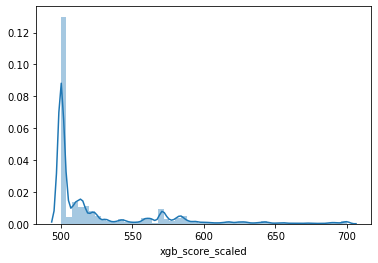

In [92]:
data_train['yj_score']=prob_train_f
data_test['yj_score']=prob_test_f
data=pd.concat([data_train,data_test],axis=0)
data['xgb_score_Inodds'] = data['yj_score'].apply(lambda x:np.log(x/(1-x)))
print((min(data['xgb_score_Inodds']),max(data['xgb_score_Inodds'])))
worst_score = 500
best_score = 700
slope = (best_score - worst_score)/(max(data['xgb_score_Inodds'])-min(data['xgb_score_Inodds']))
shift = best_score - max(data['xgb_score_Inodds'])*slope
print(slope,shift)
data['xgb_score_scaled'] = data['yj_score'].apply(lambda x:round(np.log(x/(1-x))*slope+shift))
print((min(data['xgb_score_scaled']),max(data['xgb_score_scaled'])))
sns.distplot(data['xgb_score_scaled'])

In [85]:
prob_train_n

array([0.01285771, 0.01285771, 0.01285771, ..., 0.01285771, 0.02089003,
       0.01285771], dtype=float32)

In [83]:
data_train['yj_score']

0       0.176442
1       0.176442
2       0.176442
3       0.614193
4       0.442770
          ...   
9991    0.171219
9992    0.171219
9996    0.171219
9997    0.346915
9999    0.193270
Name: yj_score, Length: 217918, dtype: float64

In [118]:
SplitPoint= unsupervisedSplit(data['xgb_score_scaled'], n_bins=10)
SplitPoint.append(np.inf)
SplitPoint.insert(0, -np.inf)
data['yj_score_cut']=pd.cut(data['xgb_score_scaled'],bins=SplitPoint)

data_ks_buket=feature_out(data['xgb_score_scaled'],data[target])

data_ks_buket.to_excel('train_bucket_xgb1.xlsx')


D:\python\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
SplitPoint=[int(var_min+i*interval_len) for i in range(1,n_bins)]

In [65]:
SplitPoint

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
data_train['yj_score_cut']=pd.cut(data_train['yj_score'],bins=SplitPoint)
data_test['yj_score_cut']=pd.cut(data_test['yj_score'],bins=SplitPoint)

train_ks_buket=feature_out(data_train['yj_score_cut'],data_train[target])
test_ks_buket=feature_out(data_test['yj_score_cut'],data_test[target])

train_ks_buket.to_excel('train_bucket_xgb5.xlsx')
test_ks_buket.to_excel('test_bucket_xgb5.xlsx')

In [48]:
from math import inf

In [51]:
data['xgb_score_scaled2'] = np.log1p(data['xgb_score_scaled'])

0

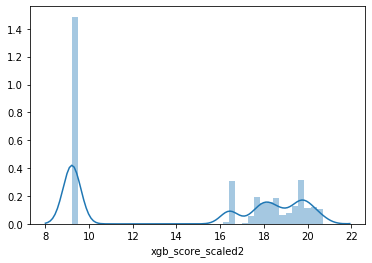

In [52]:
sns.distplot(data['xgb_score_scaled2'])

In [39]:
data['xgb_score_scaled']

0        1.0
1        1.0
2        1.0
3       77.0
4       51.0
        ... 
9990     1.0
9993     0.0
9994     0.0
9995    22.0
9998     1.0
Name: xgb_score_scaled, Length: 300000, dtype: float64

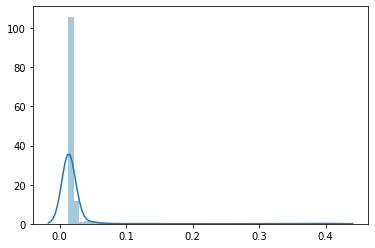

In [30]:
sns.distplot(prob_train_n,kde_kws = {'bw':0.01})

In [7]:
gamma = 0.66
alpha = 0.92
params = {'colsample_bytree': 0.6012281178978097,
  'gamma': 1.442188805100824,
  'learning_rate': 0.17103051699389016,
  'max_depth': 4,
  'min_child_weight': 1.540064965113857,
  'n_estimators': 97.32021440999489,
  'reg_alpha': 0.565447089607908,
  'reg_lambda': 95.18029272462034,
  'subsample': 0.7632340165721476,
  'eval_metric':'auc'
             }
print('----------focal loss--------')
xgb2 = xgb.train(params = params, dtrain = dtrain, num_boost_round= 100, 
                 evals=[(dtrain,'train'),(dvalid,'valid')],verbose_eval = 5,obj = logistic_obj)
print ("-----------no focal loss-----------")
xgb1 = xgb.train(params = params, dtrain = dtrain, num_boost_round= 100, 
                 evals=[(dtrain,'train'),(dvalid,'valid')],verbose_eval = 5)

----------focal loss--------
[14:17:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.80533	valid-auc:0.81446
[5]	train-auc:0.85008	valid-auc:0.85506
[10]	train-auc:0.86203	valid-auc:0.86617
[15]	train-auc:0.87108	valid-auc:0.87461
[20]	train-auc:0.87502	valid-auc:0.87717
[25]	train-auc:0.87785	valid-auc:0.87934
[30]	train-auc:0.88055	valid-auc:0.88136
[35]	train-auc:0.88293	valid-auc:0.88422
[40]	train-auc:0.88491	valid-auc:0.88439
[45]	train-auc:0.88657	valid-auc:0.88445
[50]	train-auc:0.88776	valid-auc:0.88480
[55]	train-auc:0.88925	valid-auc:0.88514
[60]	train-auc:0.89064	valid-auc:0.88565
[65]	train-auc:0.89167	valid-auc:0.88622
[70]	trai

In [10]:
#查看KS值和AUC值对比
from toad.metrics import KS,AUC
prob_test_f=xgb2.predict(dvalid)
prob_train_f=xgb2.predict(dtrain)
prob_train_f=np.array(sigmoid_function(prob_train_f))
prob_test_f=np.array(sigmoid_function(prob_test_f))
prob_test_n=xgb1.predict(dvalid)
prob_train_n=xgb1.predict(dtrain)
print('----------focal loss--------')
print('Train set:>>>>>>>>>>>>>')
print('KS:',KS(prob_train_f,train_y))
print('AUC:',AUC(prob_train_f,train_y))

print('Test set: >>>>>>>>>>>>>')
print('KS:',KS(prob_test_f,test_y))
print('AUC:',AUC(prob_test_f,test_y))


print("----------no focal loss----------")
print('Train set:>>>>>>>>>>>>>')
print('KS:',KS(prob_train_n,train_y))
print('AUC:',AUC(prob_train_n,train_y))

print('Test set: >>>>>>>>>>>>>')
print('KS:',KS(prob_test_n,test_y))
print('AUC:',AUC(prob_test_n,test_y))

----------focal loss--------
Train set:>>>>>>>>>>>>>
KS: 0.6395401716197556
AUC: 0.8993248557661868
Test set: >>>>>>>>>>>>>
KS: 0.6274347138601339
AUC: 0.8853633560801538
----------no focal loss----------
Train set:>>>>>>>>>>>>>
KS: 0.6078971426909121
AUC: 0.8687095312703729
Test set: >>>>>>>>>>>>>
KS: 0.6149077538569905
AUC: 0.8762114310049497


D:\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

(500.0, 700.0)


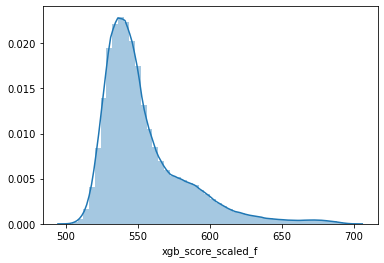

In [11]:
worst_score = 500
best_score = 700
data_train['focal_score']=prob_train_f
data_test['focal_score']=prob_test_f
data_train['xgb_score_Inodds'] = data_train['focal_score'].apply(lambda x:np.log(x/(1-x)))
data_test['xgb_score_Inodds'] = data_test['focal_score'].apply(lambda x:np.log(x/(1-x)))
slope_t = (best_score - worst_score)/(max(data_train['xgb_score_Inodds'])-min(data_train['xgb_score_Inodds']))
shift_t = best_score - max(data_train['xgb_score_Inodds'])*slope_t
data_train['xgb_score_scaled_f'] = data_train['focal_score'].apply(lambda x:round(np.log(x/(1-x))*slope_t+shift_t))
slope_v = (best_score - worst_score)/(max(data_test['xgb_score_Inodds'])-min(data_test['xgb_score_Inodds']))
shift_v = best_score - max(data_test['xgb_score_Inodds'])*slope_v
data_test['xgb_score_scaled_f'] = data_test['focal_score'].apply(lambda x:round(np.log(x/(1-x))*slope_v+shift_v))

data=pd.concat([data_train,data_test],axis=0)

print((min(data['xgb_score_scaled_f']),max(data['xgb_score_scaled_f'])))
sns.distplot(data['xgb_score_scaled_f'])
SplitPoint= unsupervisedSplit(data_train['xgb_score_scaled_f'], n_bins=20)
SplitPoint.append(700)
SplitPoint.insert(0, 500)
data_train['yj_score_cut_f']=pd.cut(data_train['xgb_score_scaled_f'],bins=SplitPoint)
data_test['yj_score_cut_f']=pd.cut(data_test['xgb_score_scaled_f'],bins=SplitPoint)
data=pd.concat([data_train,data_test],axis=0)
train_ks_buket=feature_out(data_train['yj_score_cut_f'],data_train[target])
test_ks_buket=feature_out(data_test['yj_score_cut_f'],data_test[target])

train_ks_buket.to_excel('train_bucket_xgb_f.xlsx')
test_ks_buket.to_excel('test_bucket_xgb_f.xlsx')

(595.0, 681.0)


ValueError: Bin edges must be unique: array([500, 609, 611, 612, 613, 613, 614, 615, 616, 617, 618, 619, 620,
       621, 623, 625, 628, 631, 636, 643, 700]).
You can drop duplicate edges by setting the 'duplicates' kwarg

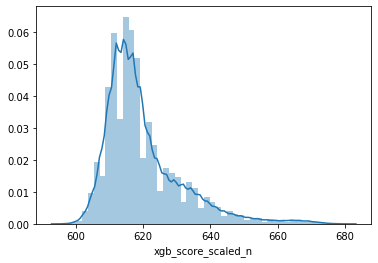

In [12]:
worst_score = 500
best_score = 700
data_train['norm_score']=prob_train_n
data_test['norm_score']=prob_test_n
data_train['xgb_score_Inodds'] = data_train['norm_score'].apply(lambda x:np.log(x/(1-x)))
data_test['xgb_score_Inodds'] = data_test['norm_score'].apply(lambda x:np.log(x/(1-x)))
slope_t = (best_score - worst_score)/(max(data_train['xgb_score_Inodds'])-min(data_train['xgb_score_Inodds']))
shift_t = best_score - max(data_train['xgb_score_Inodds'])*slope_t
data_train['xgb_score_scaled_n'] = data_train['focal_score'].apply(lambda x:round(np.log(x/(1-x))*slope_t+shift_t))
slope_v = (best_score - worst_score)/(max(data_test['xgb_score_Inodds'])-min(data_test['xgb_score_Inodds']))
shift_v = best_score - max(data_test['xgb_score_Inodds'])*slope_v
data_test['xgb_score_scaled_n'] = data_test['focal_score'].apply(lambda x:round(np.log(x/(1-x))*slope_v+shift_v))

data=pd.concat([data_train,data_test],axis=0)

print((min(data['xgb_score_scaled_n']),max(data['xgb_score_scaled_n'])))
sns.distplot(data['xgb_score_scaled_n'])
SplitPoint= unsupervisedSplit(data_train['xgb_score_scaled_n'], n_bins=20)
SplitPoint.append(700)
SplitPoint.insert(0, 500)
data_train['yj_score_cut_n']=pd.cut(data_train['xgb_score_scaled_n'],bins=SplitPoint)
data_test['yj_score_cut_n']=pd.cut(data_test['xgb_score_scaled_n'],bins=SplitPoint)

data=pd.concat([data_train,data_test],axis=0)
train_ks_buket=feature_out(data_train['yj_score_cut_n'],data_train[target])
test_ks_buket=feature_out(data_test['yj_score_cut_n'],data_test[target])

train_ks_buket.to_excel('train_bucket_xgb_n.xlsx')
test_ks_buket.to_excel('test_bucket_xgb_n.xlsx')

In [157]:
data_source_validation=data_test[['id_number_a','business_date','xgb_score_scaled_n','xgb_score_scaled_f','yj_score_cut_n','yj_score_cut_f','collection_flag']]
data_source_validation.to_csv('data_source_validation_xgb1.csv')


In [159]:
data_source_validation['collection_flag'].sum()

1362

In [150]:
data_test

,id_number_a,business_date,bal_sum_a,rating,begindate_min,collection_flag,id_number,stat_month,id_number_r,first_credit_date,...,yj_score,focal_score,xgb_score_Inodds,xgb_score_scaled,yj_score_cut,norm_score,xgb_score_scaled_f,xgb_score_scaled_n,yj_score_cut_f,yj_score_cut_n
9,441425198010100389,2021-03-31,46458.75,BB,2020-06-02,0,9445531e93b199d977cee7761e56cbf3,2021-03-01,441425198010100389,2020-02-21,...,0.003513,0.095352,-5.647874,625.0,"(624, 625]",0.003513,544.0,625.0,"(543, 545]","(624, 625]"
13,440583198412134272,2021-03-31,30706.84,BB,2020-08-09,0,e42d32f6a187130768b4ac36ed8ea42b,2021-03-01,440583198412134272,2018-08-02,...,0.004122,0.073583,-5.487224,621.0,"(620, 621]",0.004122,534.0,621.0,"(531, 536]","(620, 621]"
17,440183199509287569,2021-03-31,30436.89,A,2020-04-10,0,f2f80f520c9c0161e597c91f41db6f17,2021-03-01,440183199509287569,2019-06-20,...,0.058156,0.446537,-2.784716,655.0,"(651, 700]",0.058156,612.0,655.0,"(599, 617]","(651, 700]"
19,431125198904090011,2021-03-31,20758.00,A,2020-04-27,0,e287d5bb8c8836241936a9d95eb2f0f4,2021-03-01,431125198904090011,2018-10-10,...,0.005908,0.133270,-5.125581,630.0,"(629, 631]",0.005908,556.0,630.0,"(554, 556]","(629, 631]"
20,232302199201162722,2021-03-31,22149.83,BB,2020-11-13,0,416a414374e331ad1998d4cf1fae2925,2021-03-01,232302199201162722,2020-11-08,...,0.048134,0.424614,-2.984430,653.0,"(651, 700]",0.048134,609.0,653.0,"(599, 617]","(651, 700]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,320483199001302333,2021-03-31,32113.92,AA,2020-11-18,0,ddb161421ef89b161f0d1befa8201f71,2021-03-01,320483199001302333,2019-05-22,...,0.003050,0.070739,-5.789549,620.0,"(619, 620]",0.003050,533.0,620.0,"(531, 536]","(619, 620]"
9993,362301197112300568,2021-03-31,25000.00,A,2020-12-14,0,4c7926d8ac8a9f8c72118c42596b78ff,2021-03-01,362301197112300568,2020-06-09,...,0.004281,0.059338,-5.449198,617.0,"(615, 617]",0.004281,527.0,617.0,"(500, 531]","(615, 617]"
9994,420982198407150026,2021-03-31,22874.94,AA,2020-11-21,0,cd04bac6086b5fe6c7a0e1f57cc37b5d,2021-03-01,420982198407150026,2019-05-10,...,0.003432,0.092994,-5.671173,624.0,"(623, 624]",0.003432,543.0,624.0,"(540, 543]","(623, 624]"
9995,612326199702052320,2021-03-31,45760.00,AAA,2020-09-04,0,476ecb861f07a41c5b068ea511b12f7b,2021-03-01,612326199702052320,2020-05-08,...,0.017867,0.208097,-4.006751,638.0,"(636, 639]",0.017867,574.0,638.0,"(573, 580]","(636, 639]"


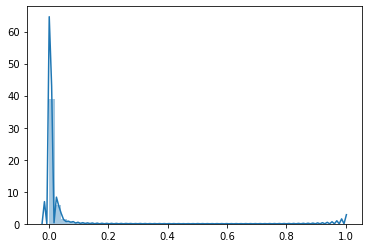

In [114]:
sns.distplot(prob_test_n)

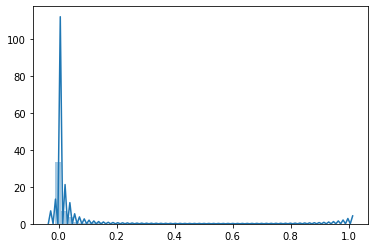

In [116]:
sns.distplot(prob_train_n)

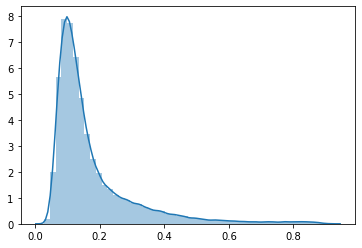

In [115]:
sns.distplot(prob_test_f)

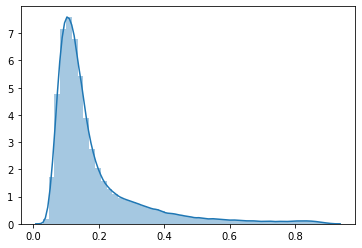

In [117]:
sns.distplot(prob_train_f)